In [369]:
import pandas as pd

## **Lire et préparation des données**

In [371]:
df = pd.read_csv("https://query.data.world/s/gl4ldmqj3t5h25s5f6lhgsj6kfkfr6?dws=00000", parse_dates={"date":["YEAR", "MONTH"]})
df["date"] = df["date"].dt.to_period("M")   # On a pas d'informations sur le jour et l'heure, seulement sur l'année et le mois

In [372]:
df.head()

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
0,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AEX,"Alexandria, LA",LA,Louisiana,US,United States
1,2015-04,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AFW,"Dallas/Fort Worth, TX",TX,Texas,US,United States
2,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,ATL,"Atlanta, GA",GA,Georgia,US,United States
3,2015-01,89,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia
4,2015-03,108,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia


In [373]:
df[df["DEST_COUNTRY"]=="GA"]

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
2629643,2001-11,0,"20,100.00",Polar Air Cargo Airways,JFK,"New York, NY",NY,New York,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
2884093,2017-06,0,"20,110.00",Antonov Company,SBD,"San Bernardino, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3017534,2009-03,0,"20,190.00",Southern Air Inc.,ATL,"Atlanta, GA",GA,Georgia,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3586633,2005-10,0,"20,308.00",Centurion Cargo Inc.,MIA,"Miami, FL",FL,Florida,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585680,2008-08,0,"20,428.00",Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585681,2012-11,0,"20,428.00",Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585972,2005-10,0,"20,428.00",Volga-Dnepr Airlines,LAX,"Los Angeles, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon


<Axes: title={'center': 'Nombre de passagers mensuel ayant pour destination FR'}, xlabel='Date (mois et année)', ylabel='Nombre de passagers'>

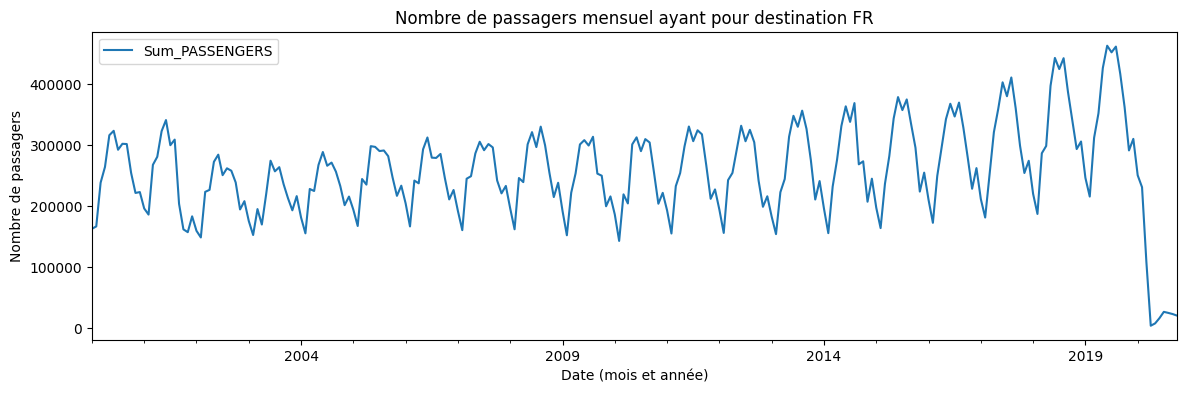

In [374]:
# Nombre de passagers allant dans un pays chaque mois
country_code = "FR"
data = df[df["DEST_COUNTRY"]==country_code][["date", "Sum_PASSENGERS"]].groupby("date").sum()
data.plot(title=f"Nombre de passagers mensuel ayant pour destination {country_code}",
          xlabel="Date (mois et année)",
          ylabel="Nombre de passagers",
          figsize=(14,4))

## **Décomposition STL**

In [375]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

In [376]:
nb_passengers = data["Sum_PASSENGERS"].values

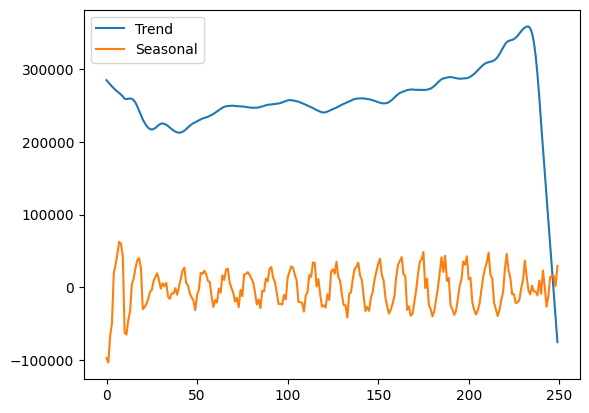

In [377]:
stl = STL(nb_passengers, period=10)
result = stl.fit()
plt.plot(result.trend, label="Trend")
plt.plot(result.seasonal, label="Seasonal")
plt.legend()

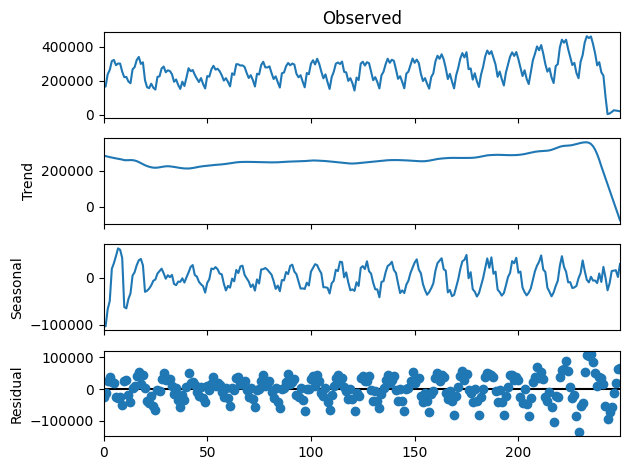

In [378]:
result.plot()
plt.show()

## **Prédictions naïves**

In [379]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [380]:
def plot_ys(*args, **kwargs):
        # restore 2020 behaviour (jfb) --> plot_ys supprimé
        nb_series=len(args)
        plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

In [381]:
y_train, y_test = temporal_train_test_split(nb_passengers, test_size=30)

In [382]:
print(type(y_train))
print(y_train.shape)

print(type(y_test))
print(y_test.shape)

<class 'numpy.ndarray'>
(220, 1)
<class 'numpy.ndarray'>
(30, 1)


In [383]:
# y_train = pd.Series(y_train)
# y_test = pd.Series(y_test)

y_train = pd.Series(y_train.flatten())
y_test = pd.Series(y_test.flatten())

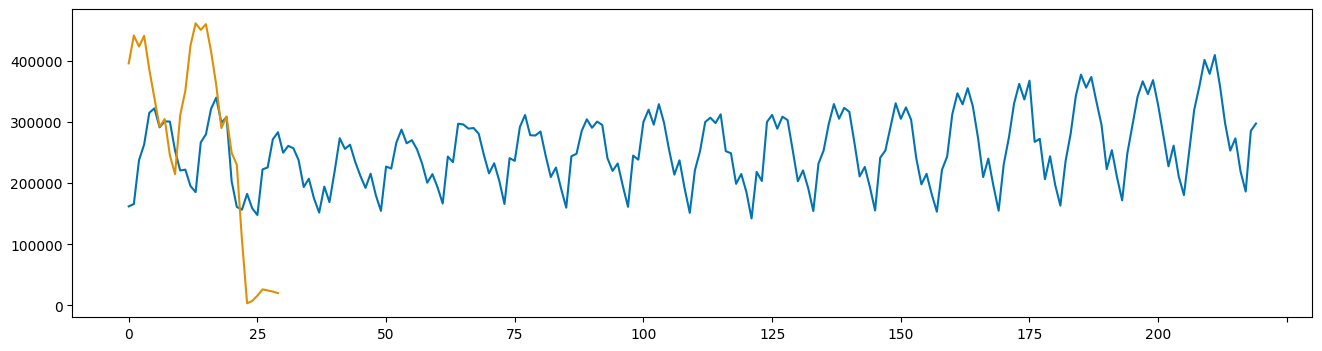

In [384]:
plot_ys(y_train, y_test)

SMAPE_LOSS: 6.638233162761259


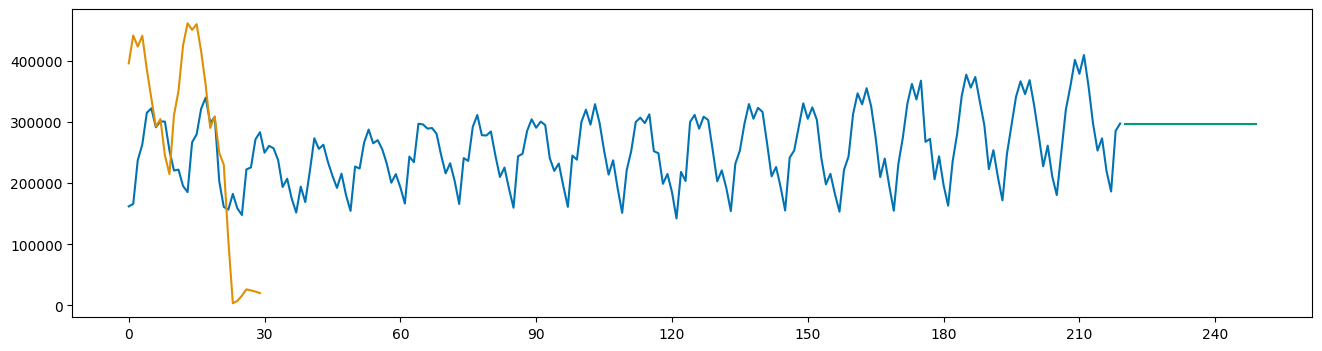

In [385]:
fh = np.arange(1,len(y_test)+1)

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 6.189660914954509


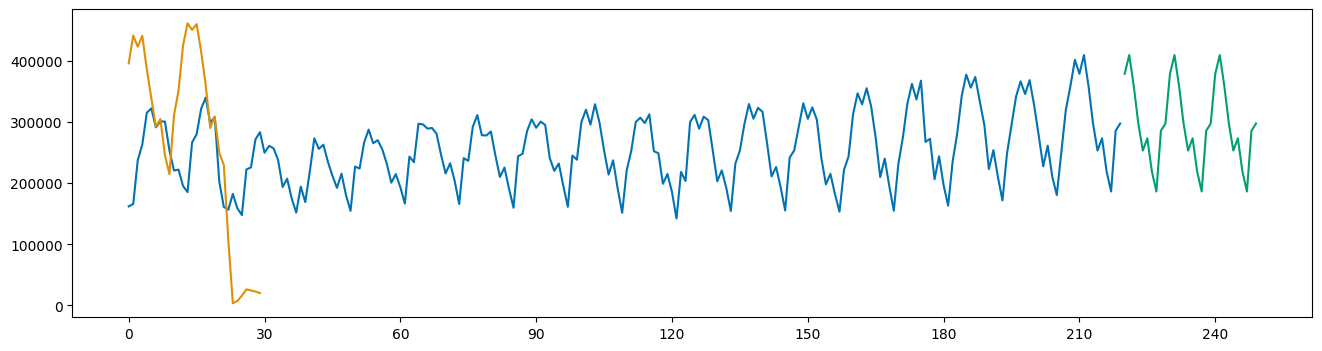

In [386]:
forecaster = NaiveForecaster(strategy='last', sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

## **Prédictions**

In [387]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

SMAPE_LOSS: 7.089318511684448


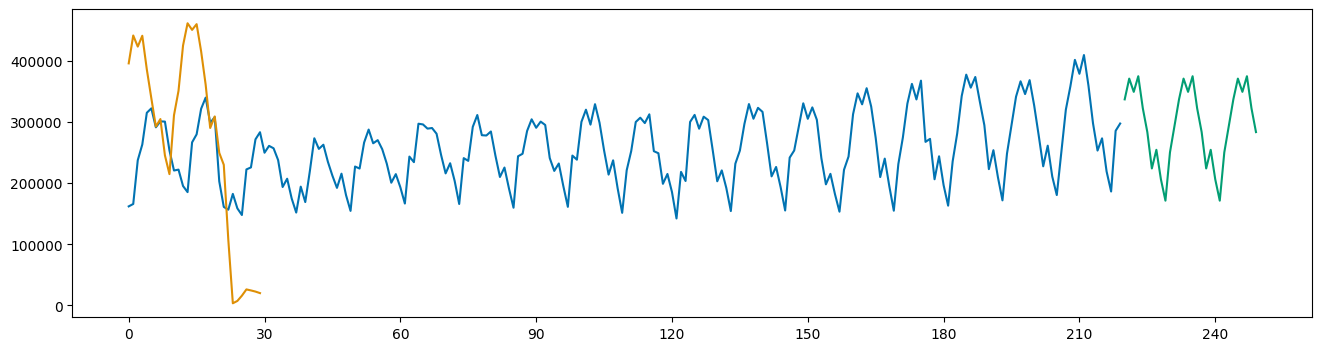

In [388]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 7.576284960614917


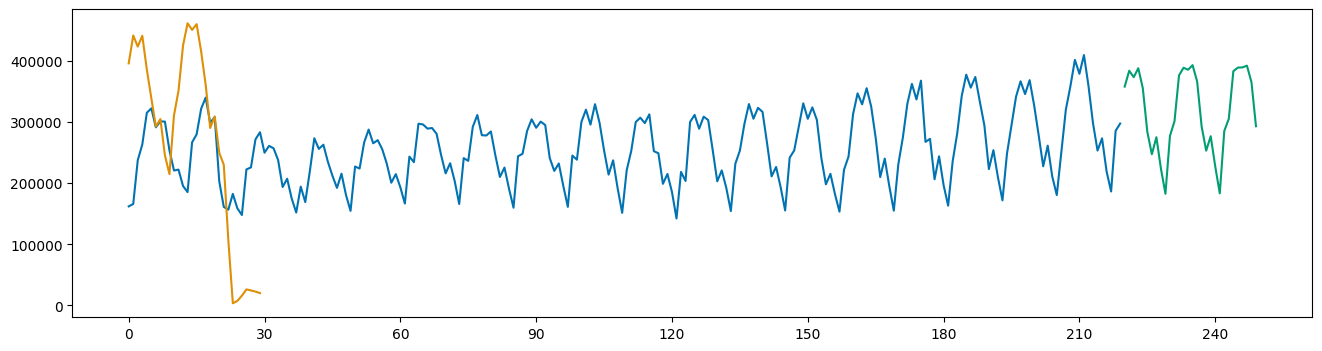

In [389]:
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 5.4919569697475605


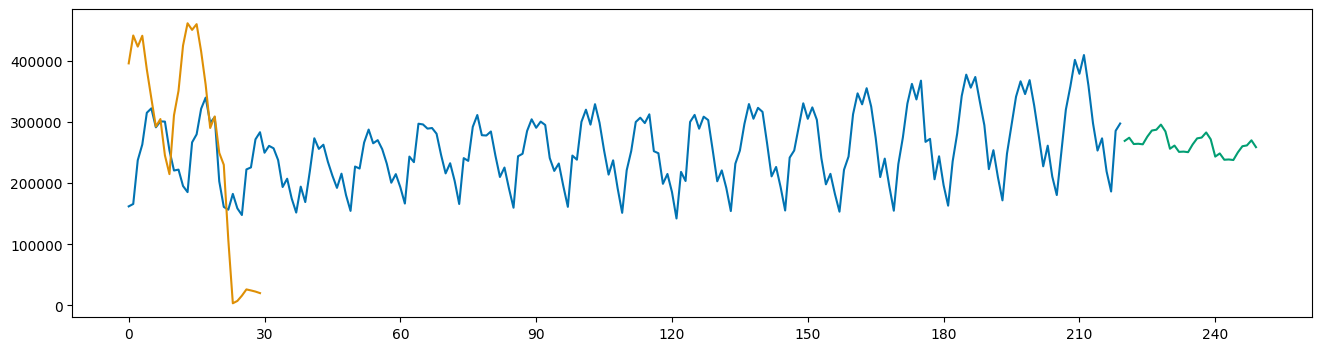

In [390]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive",
                                  sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

## Prédiction Deep Learning

### Data Prep

In [391]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [392]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [393]:
data

,Sum_PASSENGERS
date,
2000-01,162078
2000-02,166025
2000-03,237683
2000-04,263418
2000-05,315368
...,...
2020-06,15821
2020-07,26105
2020-08,24425


In [394]:
#data.set_index('date', inplace=True)

In [395]:
valid_start_dt = '2019-01'
test_start_dt = '2020-01'

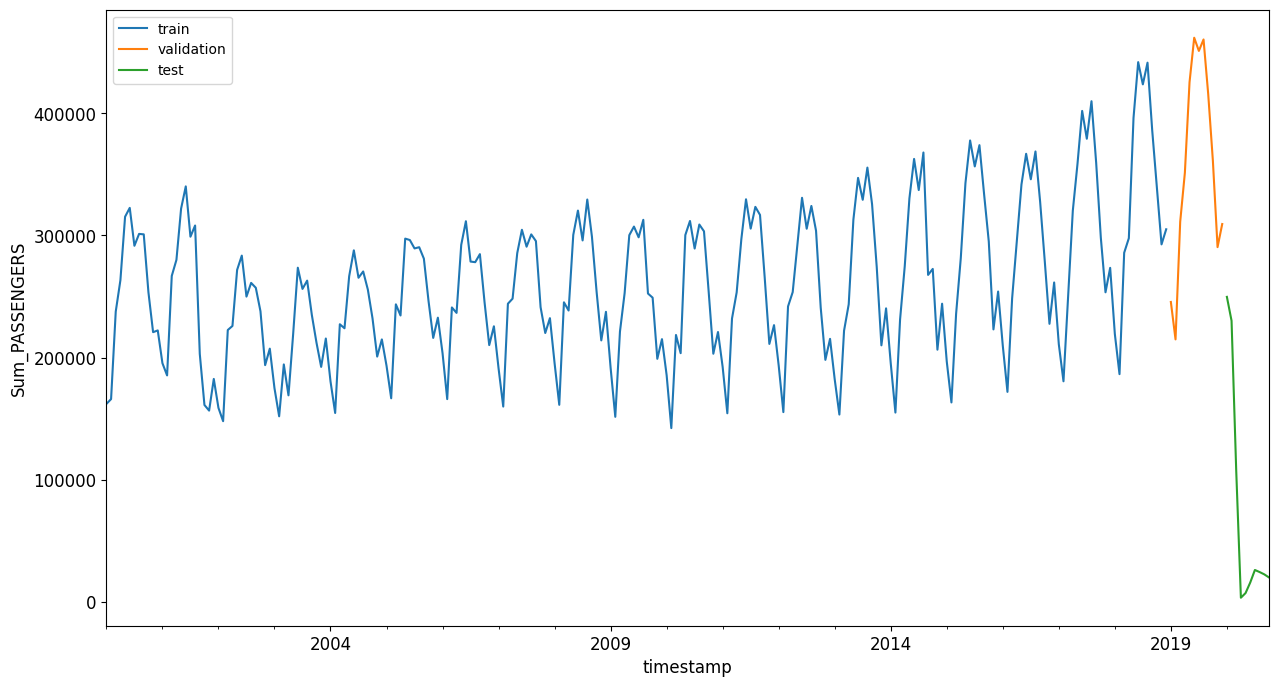

In [396]:
# df[df['date'] < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'train'}) \
#     .join(df[(df['date'] >=valid_start_dt) & (df['date'] < test_start_dt)][['Sum_PASSENGERS']] \
#           .rename(columns={'Sum_PASSENGERS':'validation'}), how='outer') \
#     .join(df[test_start_dt:][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'test'}), how='outer') \
#     .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
data[data.index < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS': 'train'}) \
    .join(data[(data.index >= valid_start_dt) & (data.index < test_start_dt)][['Sum_PASSENGERS']] \
          .rename(columns={'Sum_PASSENGERS': 'validation'}), how='outer') \
    .join(data[test_start_dt:][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS': 'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Sum_PASSENGERS', fontsize=12)
plt.show()

In [397]:
T = 3
HORIZON = 1

In [398]:
train = data.copy()[data.index < valid_start_dt][['Sum_PASSENGERS']]

In [399]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['Sum_PASSENGERS'] = scaler.fit_transform(train)
train.head(10)

,Sum_PASSENGERS
date,
2000-01,0.07
2000-02,0.08
2000-03,0.32
2000-04,0.40
2000-05,0.58
2000-06,0.60
2000-07,0.50
2000-08,0.53
2000-09,0.53


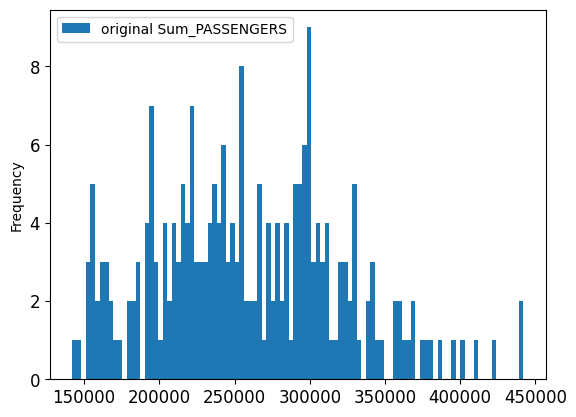

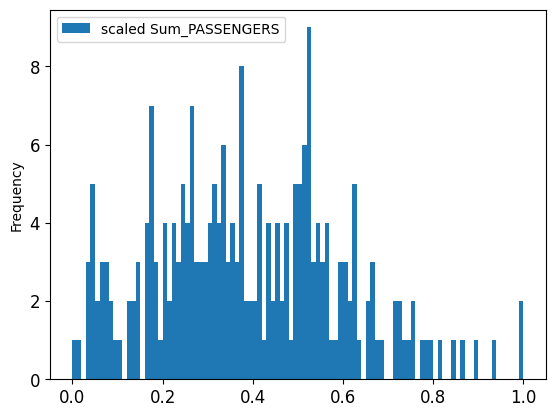

In [400]:
data[data.index < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'original Sum_PASSENGERS'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Sum_PASSENGERS':'scaled Sum_PASSENGERS'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [401]:
train

,Sum_PASSENGERS
date,
2000-01,0.07
2000-02,0.08
2000-03,0.32
2000-04,0.40
2000-05,0.58
...,...
2018-08,1.00
2018-09,0.81
2018-10,0.66


In [402]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
train_shifted.head(10)

,Sum_PASSENGERS,y_t+1
date,,
2000-01,0.07,0.08
2000-02,0.08,0.32
2000-03,0.32,0.40
2000-04,0.40,0.58
2000-05,0.58,0.60
2000-06,0.60,0.50
2000-07,0.50,0.53
2000-08,0.53,0.53
2000-09,0.53,0.37


In [403]:
for t in range(1, T+1):
    train_shifted['Sum_PASSENGERS_t-'+str(T-t)] = train_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
train_shifted = train_shifted.rename(columns={'Sum_PASSENGERS':'Sum_PASSENGERS_original'})
train_shifted.head(10)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,
2000-01,0.07,0.08,NaN,NaN,0.07
2000-02,0.08,0.32,NaN,0.07,0.08
2000-03,0.32,0.40,0.07,0.08,0.32
2000-04,0.40,0.58,0.08,0.32,0.40
2000-05,0.58,0.60,0.32,0.40,0.58
2000-06,0.60,0.50,0.40,0.58,0.60
2000-07,0.50,0.53,0.58,0.60,0.50
2000-08,0.53,0.53,0.60,0.50,0.53
2000-09,0.53,0.37,0.50,0.53,0.53


In [404]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,
2000-03,0.32,0.40,0.07,0.08,0.32
2000-04,0.40,0.58,0.08,0.32,0.40
2000-05,0.58,0.60,0.32,0.40,0.58
2000-06,0.60,0.50,0.40,0.58,0.60
2000-07,0.50,0.53,0.58,0.60,0.50


In [405]:
y_train = train_shifted[['y_t+1']].to_numpy()

In [406]:
y_train.shape

(225, 1)

In [407]:
y_train[:3]

array([[0.4 ],
       [0.58],
       [0.6 ]])

In [408]:
X_train = train_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

In [409]:
X_train.shape

(225, 3, 1)

In [410]:
X_train[:3]

array([[[0.07],
        [0.08],
        [0.32]],

       [[0.08],
        [0.32],
        [0.4 ]],

       [[0.32],
        [0.4 ],
        [0.58]]])

In [411]:
train_shifted.head(3)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,
2000-03,0.32,0.40,0.07,0.08,0.32
2000-04,0.40,0.58,0.08,0.32,0.40
2000-05,0.58,0.60,0.32,0.40,0.58


In [412]:
from dateutil.relativedelta import relativedelta

In [413]:
relativedelta(months=T-1)

relativedelta(months=+2)

In [414]:
#valid_start_dt.strftime('%Y-%m')

In [415]:
#dt.datetime.strptime(valid_start_dt.strftime('%Y-%m'), '%Y-%m')

In [416]:
#data.index

In [417]:
#valid_start_dt

In [418]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m') - relativedelta(months=T-1)
look_back_dt = look_back_dt.strftime('%Y-%m')
valid = data.copy()[(data.index >=look_back_dt) & (data.index < test_start_dt)][['Sum_PASSENGERS']]
valid.head()

,Sum_PASSENGERS
date,
2018-11,292722
2018-12,305086
2019-01,245582
2019-02,214925
2019-03,311271


In [419]:
valid['Sum_PASSENGERS'] = scaler.transform(valid)
valid.head()

,Sum_PASSENGERS
date,
2018-11,0.50
2018-12,0.54
2019-01,0.34
2019-02,0.24
2019-03,0.56


In [420]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
for t in range(1, T+1):
    valid_shifted['Sum_PASSENGERS_t-'+str(T-t)] = valid_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [421]:
y_valid.shape

(11,)

In [422]:
X_valid.shape

(11, 3, 1)

### CNN

In [423]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [424]:
LATENT_DIM = 5 # Nombre de filtres
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [425]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [426]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 3, 5)              15        
                                                                 
 conv1d_13 (Conv1D)          (None, 3, 5)              55        
                                                                 
 conv1d_14 (Conv1D)          (None, 3, 5)              55        
                                                                 
 flatten_4 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [427]:
model.compile(optimizer='Adam', loss='mse')

In [428]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [429]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [430]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
8/8 [==============================] - 2s 58ms/step - loss: 0.1467 - val_loss: 0.4259
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 0.1138 - val_loss: 0.3468
Epoch 3/10
8/8 [==============================] - 0s 15ms/step - loss: 0.0874 - val_loss: 0.2794
Epoch 4/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0659 - val_loss: 0.2203
Epoch 5/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0498 - val_loss: 0.1706
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0395 - val_loss: 0.1356
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0348 - val_loss: 0.1115
Epoch 8/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0329 - val_loss: 0.1047
Epoch 9/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0326 - val_loss: 0.1025
Epoch 10/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0323 - val_loss: 0.0958


In [431]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

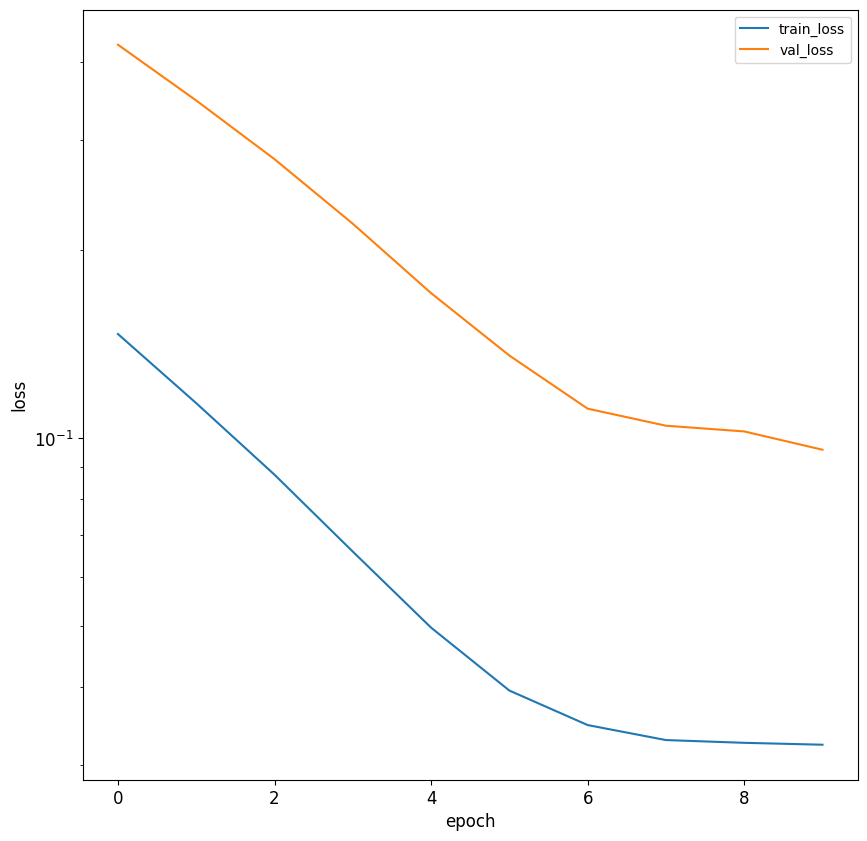

In [432]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [433]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m') - relativedelta(months=T-1)
look_back_dt = look_back_dt.strftime('%Y-%m')
test = data.copy()[test_start_dt:][['Sum_PASSENGERS']]
test.head()

,Sum_PASSENGERS
date,
2020-01,249749
2020-02,230197
2020-03,107377
2020-04,3389
2020-05,7214


In [434]:
test['Sum_PASSENGERS'] = scaler.transform(test)
test.head()

,Sum_PASSENGERS
date,
2020-01,0.36
2020-02,0.29
2020-03,-0.12
2020-04,-0.46
2020-05,-0.45


In [435]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
for t in range(1, T+1):
    test_shifted['Sum_PASSENGERS_t-'+str(T-t)] = test_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

In [436]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 0s 120ms/step


array([[0.34],
       [0.25],
       [0.16],
       [0.17],
       [0.17],
       [0.16],
       [0.16]], dtype=float32)

In [437]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='m')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,m,prediction,actual
0,2020-03,t+1,"244,476.46","3,389.00"
1,2020-04,t+1,"218,586.27","7,214.00"
2,2020-05,t+1,"191,134.74","15,821.00"
3,2020-06,t+1,"192,404.97","26,105.00"
4,2020-07,t+1,"192,624.37","24,425.00"


In [451]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [452]:
mape(eval_df['prediction'], eval_df['actual'])

14.948646272979747

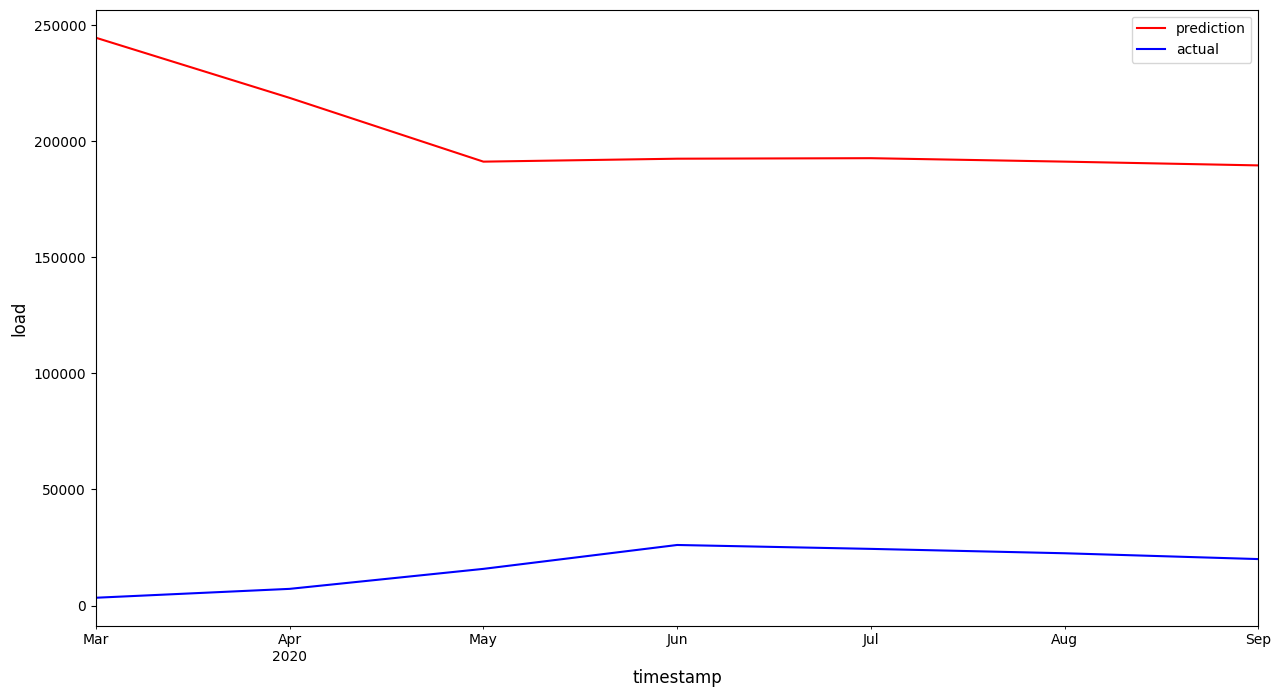

In [439]:
eval_df[eval_df.timestamp<'2022-12'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

### RNN

In [440]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [441]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [442]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [443]:
model.compile(optimizer='RMSprop', loss='mse')

In [444]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5)                 120       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 126 (504.00 Byte)
Trainable params: 126 (504.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [445]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [446]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 11s 284ms/step - loss: 0.0958 - val_loss: 0.2784
Epoch 2/10
8/8 [==============================] - 0s 49ms/step - loss: 0.0635 - val_loss: 0.2253
Epoch 3/10
8/8 [==============================] - 0s 25ms/step - loss: 0.0480 - val_loss: 0.1796
Epoch 4/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0368 - val_loss: 0.1533
Epoch 5/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0316 - val_loss: 0.1370
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0288 - val_loss: 0.1110
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0260 - val_loss: 0.1091
Epoch 8/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0258 - val_loss: 0.1020
Epoch 9/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0251 - val_loss: 0.0829
Epoch 10/10
8/8 [==============================] - 0s 16ms/step - loss: 0.0247 - val_loss: 0.0901


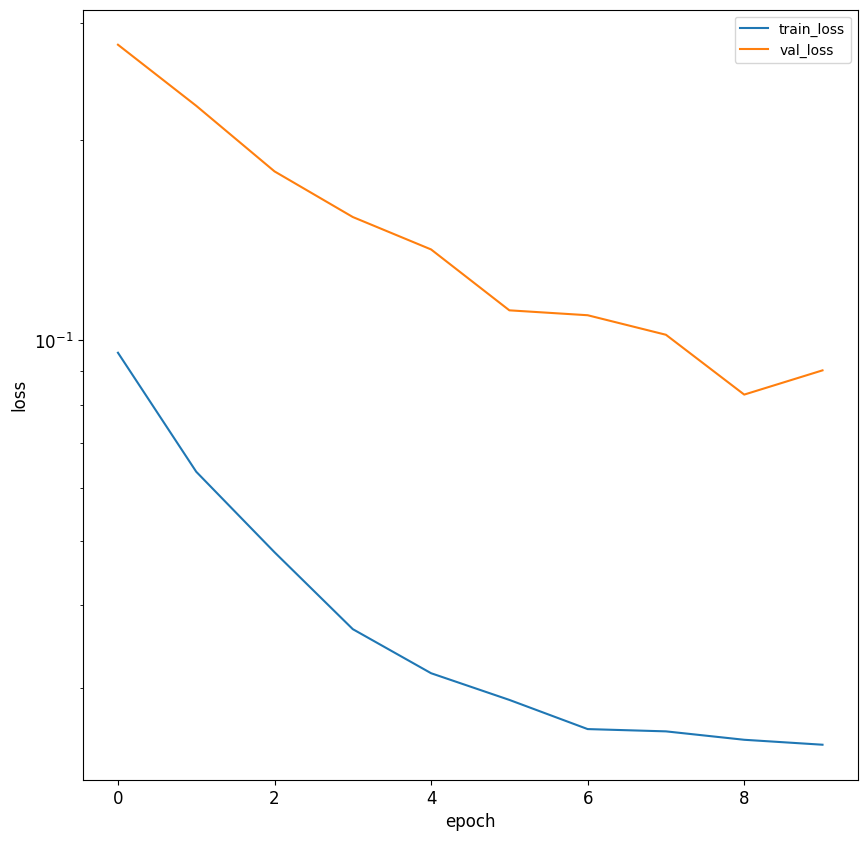

In [447]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [448]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 1s 962ms/step


array([[ 0.2 ],
       [ 0.02],
       [-0.04],
       [-0.05],
       [-0.03],
       [-0.02],
       [-0.03]], dtype=float32)

In [449]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='m')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,m,prediction,actual
0,2020-03,t+1,"202,517.73","3,389.00"
1,2020-04,t+1,"148,353.83","7,214.00"
2,2020-05,t+1,"130,260.10","15,821.00"
3,2020-06,t+1,"128,435.14","26,105.00"
4,2020-07,t+1,"133,500.98","24,425.00"


In [453]:
mape(eval_df['prediction'], eval_df['actual'])

14.948646272979747

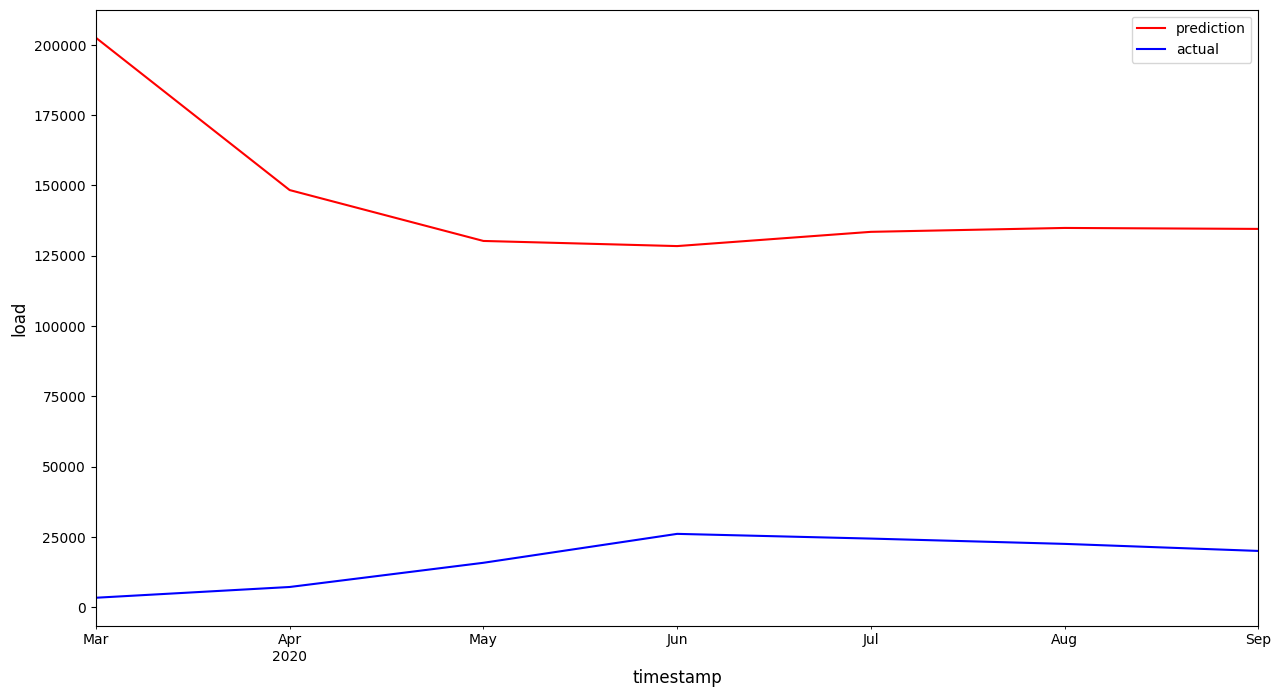

In [450]:
eval_df[eval_df.timestamp<'2022-12'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()